# Initialization:

In [1]:
import pandas as pd
import re
from datetime import datetime
from tqdm import tqdm
import json
from glob import glob
import emoji
import math
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import numpy as np
import vivino
from sklearn.utils import shuffle

import spacy
nlp = spacy.load('en_core_web_sm-wine', disable=['better'])

TOKEN = 'PRICETOKEN'


folder_raw_vivino = './raw_vivino_data/'
folder_vivino = './vivino_data/'
keep_columns = [
    'rating',
    'note',
    'language',
    'created_at',
    'user.id',
    'user.seo_name',
    'user.alias',
    'user.statistics.followers_count',
    'user.statistics.followings_count',
    'user.statistics.ratings_count',
    'user.statistics.ratings_sum',
    'user.statistics.reviews_count',
    'vintage.id',
    'vintage.seo_name',
    'vintage.name',
    'vintage.statistics.status',
    'vintage.image.location',
    'vintage.statistics.ratings_count',
    'vintage.statistics.ratings_average',
    'vintage.statistics.reviews_count',
    'vintage.wine.name',
    'vintage.wine.region.name',
    'vintage.wine.region.country.name',
    'vintage.wine.winery.name',
    'vintage.wine.winery.statistics.ratings_count',
    'vintage.wine.winery.statistics.ratings_average',
    'vintage.wine.winery.statistics.labels_count',
    'vintage.wine.winery.statistics.wines_count',
    'flavor_word_matches',
    'activity.statistics.likes_count',
    'activity.statistics.comments_count',
    'vintage.year',
]
rename_columns = [
    'ratings',
    'reviews',
    'language',
    'time',
    'user.id',
    'user.user',
    'user.name',
    'user.followers_count',
    'user.followings_count',
    'user.ratings_count',
    'user.ratings_sum',
    'user.reviews_count',
    'vintage.id',
    'vintage.seo',
    'vintage.name',
    'vintage.status',
    'vintage.image',
    'wine.ratings_count',
    'wine.ratings_average',
    'wine.reviews_count',
    'wine.name',
    'wine.region',
    'wine.country',
    'winery.name',
    'winery.ratings_count',
    'winery.ratings_average',
    'winery.labels_count',
    'winery.wines_count',
    'flavours',
    'likes_count',
    'comments_count',
    'vintage.year',
]

rename_dict = dict(zip(keep_columns, rename_columns))

# NLP Pre-processing

## Reviews with a single $ symbol

In [2]:
folder_vivino = './vivino_data/'
#fname_list = [f.replace('\\', '/') for f in glob(folder_vivino + 'vivino_*')]
#users = set([])

def has_numbers(inputString):
    try:
        return bool(re.search(r'\d', inputString))
    except:
        #print('FAILURE:', inputString, type(inputString))
        return False

def has_single_dollarsign(inputString):
    try:
        num = inputString.lower().count('$')
        if num == 1:
            return True
        return False
    except:
        #print('FAILURE:', inputString, type(inputString))
        return False

In [3]:
fname_list = glob(folder_vivino + 'vivino_*')
reviews = []
ratings = []
num_reviews = 0
col_names = pd.read_csv(fname_list[0], encoding='utf-8-sig').columns
df_master = pd.DataFrame(columns=col_names)

df_list = []

for fname in tqdm(fname_list):
    df = pd.read_csv(fname, encoding='utf-8-sig')
    df['Vivino ID'] = int(fname.split('_')[-1].split('.')[0])  #Get Vivino ID
    df = df[(df['reviews'].apply(has_numbers))
            & (df['reviews'].apply(has_single_dollarsign))
            & (df['detected_language'] == 'ENGLISH')]
    df_list.append(df)
df_master = pd.concat(df_list, ignore_index=True)
df_master.to_csv('master_vivino.csv', encoding='utf-8-sig')
print('Number of reviews:', len(df_master))
print('Number of unique bottles:', len(df_master['Vivino ID'].unique()))

100%|██████████| 6955/6955 [03:01<00:00, 38.26it/s]


Number of reviews: 53888
Number of unique bottles: 3957


### Plot histogram results of reviews containing numbers and a single $ symbol

In [4]:
df_master = pd.read_csv('./master_vivino.csv', encoding='utf-8-sig')

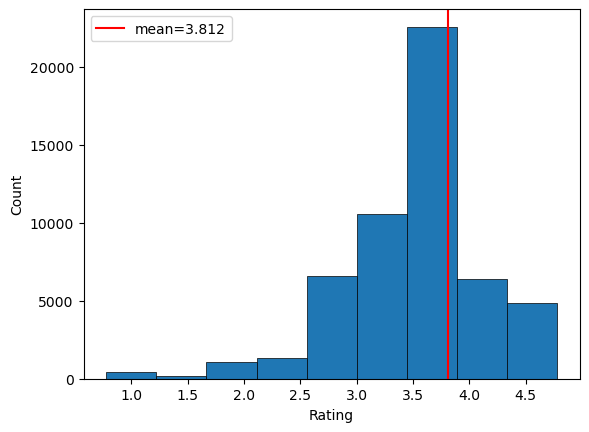

In [5]:
plt.hist(df_master['ratings'], align='left', bins=9, edgecolor='black', linewidth=0.5)
plt.xlabel('Rating')
plt.ylabel('Count')
d = df_master['ratings'].describe()
plt.axvline(d[1],label=f'mean={str(d[1])[0:5]}', c = 'r')
plt.legend()

onestar = df_master[(df_master['ratings']<=2)]['ratings'].count()
fivestar = df_master[(df_master['ratings']>=4)]['ratings'].count()

Number of bottles with >= 100 reviews: 83
Number of bottles with  < 100 reviews: 3874


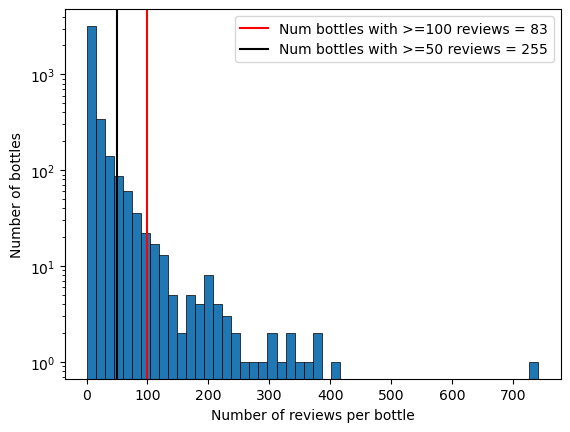

In [6]:
nbins = 50
y = df_master.groupby(['Vivino ID'])['Vivino ID'].count()
plt.hist(y,  bins=nbins, edgecolor='black', linewidth=0.5)
# plt.xlim(0,10)
plt.semilogy()
# print(max(y))
plt.xlabel('Number of reviews per bottle')
plt.ylabel('Number of bottles')

cut = 100
print('Number of bottles with >=', cut, 'reviews:', len(y[(y >= cut)]))
print('Number of bottles with  <', cut, 'reviews:', len(y[(y < cut)]))
plt.axvline(cut, label=f'Num bottles with >={cut} reviews = {len(y[(y >= cut)])}', c = 'r')
cut = 50
plt.axvline(cut, label=f'Num bottles with >={cut} reviews = {len(y[(y >= cut)])}', c = 'k')
plt.legend()

## Keywords related to wine

### Collect and save english reviews without numbers

In [7]:
fname_list = glob(folder_vivino + 'vivino_*')
reviews = []
ratings = []
num_reviews = 0
col_names = pd.read_csv(fname_list[0], encoding='utf-8-sig').columns
df_master = pd.DataFrame(columns=col_names)

df_list = []

for fname in tqdm(fname_list):
    df = pd.read_csv(fname, encoding='utf-8-sig')
    df['Vivino ID'] = int(fname.split('_')[-1].split('.')[0])  # Get Vivino ID
    df = df[(~df['reviews'].apply(has_numbers))
            & (df['detected_language'] == 'ENGLISH')]
    df_list.append(df)
df_english = pd.concat(df_list, ignore_index=True).astype(str)
df_english.to_csv('english_nonumbers_vivino.csv', encoding='utf-8-sig')

100%|██████████| 6955/6955 [01:48<00:00, 64.09it/s] 


In [8]:
len(df_english)

3208165

### Most interesting words in wine reviews: TF-IDF

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS
import spacy
import re
nlp = spacy.load("en_core_web_sm")
STOP_WORDS = STOP_WORDS.difference({'he', 'his', 'her', 'hers'})
STOP_WORDS = STOP_WORDS.union({'ll', 've'})
STOP_WORDS = STOP_WORDS.union({''})

with open('spacy_stop_words_original.txt', 'w', encoding='utf-8') as f:
    f.write('\n'.join(STOP_WORDS))
def tokenize_lemma(text):
    return [re.sub('[^A-Za-z0-9]+', '', w.lemma_.lower().strip()) for w in nlp(text)]

stop_words_lemma = set(tokenize_lemma(' '.join(sorted(STOP_WORDS))))

In [10]:
df_english = pd.read_csv('english_nonumbers_vivino.csv', encoding='utf-8-sig')

C:\Users\steph\AppData\Local\Temp\ipykernel_17672\1538605931.py:1: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  df_english = pd.read_csv('english_nonumbers_vivino.csv', encoding='utf-8-sig')


In [12]:
#nsamples = 100000
#reviews_sent = [s.text for r in df_english['reviews'].astype(str).sample(n=nsamples) for s in nlp(r).sents]
#len(reviews_sent)

In [13]:
ng_tfidf = TfidfVectorizer(ngram_range=(1, 1), stop_words=stop_words_lemma, max_features=500, tokenizer=tokenize_lemma)
ng_tfidf.fit(df_english['reviews'].astype(str).sample(n=100000))
tf_words = ng_tfidf.get_feature_names_out()
tf_words

C:\Users\steph\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


array(['absolutely', 'acid', 'acidic', 'acidity', 'actually', 'add',
       'affordable', 'aftertaste', 'age', 'aged', 'air', 'alcohol',
       'almond', 'amarone', 'amazing', 'anise', 'apple', 'apricot',
       'aroma', 'aromatic', 'average', 'awesome', 'bad', 'bake',
       'balance', 'balanced', 'barrel', 'base', 'bbq', 'beautiful',
       'beautifully', 'beef', 'berry', 'big', 'bit', 'bite', 'bitter',
       'black', 'blackberry', 'blackcurrant', 'blanc', 'blend', 'blue',
       'blueberry', 'bodied', 'body', 'bold', 'bordeaux', 'bottle',
       'bouquet', 'box', 'bread', 'breath', 'breathe', 'bright', 'bring',
       'brioche', 'brown', 'brunello', 'bubble', 'bubbly', 'burgundy',
       'butter', 'buttery', 'buy', 'cab', 'cabernet', 'california',
       'candy', 'caramel', 'cassis', 'cedar', 'cellar', 'champagne',
       'character', 'characteristic', 'chard', 'chardonnay', 'cheap',
       'cheer', 'cheese', 'cherry', 'chianti', 'chicken', 'chill',
       'chocolate', 'choice', 'c

In [43]:
with open('tfidf_words.txt', 'w') as f:
    f.write('\n'.join(tf_words))

## Sample reviews without stopwords:

In [ ]:
# import spacy
# nlp = spacy.load("en_core_web_sm")
# nlp.get_pipe('lemmatizer').cache = {}

# def fix_lemma_rule(s):
#    nlp.get_pipe('lemmatizer').lookups.get_table("lemma_exc")[nlp(s)[0].pos_.lower()][s] = [s]
# fix_lemma_rule('better')
# nlp.to_disk('./en_core_web_sm-wine')

In [14]:
import emoji
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS
import spacy
import re
import pandas as pd
nlp = spacy.load("en_core_web_sm-wine")

def tokenize_lemma(text):
    return [re.sub('[^A-Za-z0-9]+', '', w.lemma_.lower().strip()) for w in nlp(emoji.replace_emoji(text))]


In [15]:
df_money = pd.read_csv('master_vivino.csv', encoding='utf-8-sig')

sample_reviews = list(df_money[(df_money['ratings']<3)]['reviews'].astype(str).sample(n=100))

In [16]:
sum(df_money['Vivino ID'].value_counts()>0)

3957

In [17]:
with open('wine_words.txt') as file:
    stop_words_wine = [line.rstrip() for line in file]
with open('custom_stop_words.txt') as file:
    stop_words = [line.rstrip() for line in file]
with open('vivino_stop_words.txt') as file:
    stop_words_vivino = [line.rstrip() for line in file]
STOP_WORDS = set(stop_words+stop_words_wine+stop_words_vivino)
stop_words_lemma = set(tokenize_lemma(' '.join(sorted(STOP_WORDS))))


In [18]:
for s in sample_reviews[0:10]:
    s = emoji.replace_emoji(s)
    text_tokens = tokenize_lemma(s)
    tokens_without_sw = [word for word in text_tokens if not word in STOP_WORDS]
    print(s)
    print(tokens_without_sw)
    print()

Barely worth $5
['barely', 'worth', '5']

I’ve had better $12.00 wines
['well', '1200']

Not bad for $6. First impression was nice. Dry, Dark Berries. But after that it falls Flat. This wine had No Finnish... I give it a 2.5 Overall, but 3.5 for Value... If there were only more Tannins to leave something on your palette... I'll buy it again at that price though...
['not', 'bad', '6', 'impression', 'nice', 'dry', 'berries', 'but', 'after', 'fall', 'flat', 'no', 'finnish', '25', 'overall', 'but', '35', 'value', 'more', 'leave', 'palette', 'buy', 'again', 'price']

Clean, clear, legs, unfiltered , cedar, jammy, licorice , cloves, best $45ish dollars for dinner.
['clean', 'clear', 'unfiltered', 'good', '45ish', 'dollar']

Dense, tannins and some oak. Hmm. Pretty raw. For years this was my favourite cab when it had to be a special occasion to spend $16 on wine. There are so many better cabs at this price, Jacobs Creek or Penfolds for instance, this just does not cut it any more. Reminds me 

### problems:

I’ve tasted better $10 wines.
['taste', 'well', '10']

## Get random positive and negative reviews with prices. Save for training data.

In [19]:
df_money = pd.read_csv('master_vivino.csv', encoding='utf-8-sig')
ndraw = 2000
pos = df_money[(df_money['ratings']>3)][['reviews','ratings']].astype(str).sample(n=ndraw)
neg = df_money[(df_money['ratings']<3)][['reviews','ratings']].astype(str).sample(n=ndraw)
print(len(pos),len(neg))
data = pd.concat([pos,neg], ignore_index=True)

2000 2000


In [20]:
df_data = pd.DataFrame({'reviews':data['reviews'], 'sentiment':['']*len(data)})
df_data['reviews'] = df_data['reviews'].apply(emoji.replace_emoji)
df_data = df_data.sample(len(df_data))
df_data.to_csv('sample_reviews.csv', encoding='utf-8-sig')

In [21]:
data_h0 = data.copy(deep=True)
def simple_sentiment(s):
    s = float(s)
    if s >3:
        return 'Positive'
    elif s < 3:
        return 'Negative'
    else:
        return 'Neutral'
import random
data_h0['sentiment'] = data_h0['ratings'].apply(simple_sentiment)
data_h0 = data_h0[['reviews','sentiment']]
data_h0.sample(5)
data_h0.to_csv('./survey_results/ratings_sentiment.csv', encoding='utf-8-sig')
#data_h0['sentiment'].value_counts()

## Reviews with Star-rating sentiments. 5 stars = pos, 1 star = neg

In [22]:
data = pd.read_csv('./survey_results/master_survey.csv', encoding='utf-8-sig')
data = pd.read_csv('./english_nonumbers_vivino.csv', encoding='utf-8-sig')

C:\Users\steph\AppData\Local\Temp\ipykernel_17672\3070824384.py:2: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('./english_nonumbers_vivino.csv', encoding='utf-8-sig')


In [23]:
len(data)
data.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'ratings', 'reviews', 'language', 'time',
       'user.id', 'user.user', 'user.name', 'user.followers_count',
       'user.followings_count', 'user.ratings_count', 'user.ratings_sum',
       'user.reviews_count', 'vintage.id', 'vintage.seo', 'vintage.name',
       'vintage.status', 'vintage.image', 'wine.ratings_count',
       'wine.ratings_average', 'wine.reviews_count', 'wine.name',
       'wine.region', 'wine.country', 'winery.name', 'winery.ratings_count',
       'winery.ratings_average', 'winery.labels_count', 'winery.wines_count',
       'flavours', 'likes_count', 'comments_count', 'vintage.year',
       'detected_language', 'Vivino ID'],
      dtype='object')

In [24]:
data2 = data[0:1000000]

In [25]:
pos = data2[(data2['ratings']>=5)]
neg = data2[(data2['ratings']<=2)]
print(len(neg), len(pos))

33127 142504


In [26]:
pos['sentiment'] = 'positive'
neg['sentiment'] = 'negative'
pos = pos[0:len(neg)]
df_starsentiment = pd.concat([pos,neg]).sample(frac=1).reset_index(drop=True)

C:\Users\steph\AppData\Local\Temp\ipykernel_17672\3832399575.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos['sentiment'] = 'positive'
C:\Users\steph\AppData\Local\Temp\ipykernel_17672\3832399575.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg['sentiment'] = 'negative'


In [27]:
df_starsentiment

,Unnamed: 0.1,Unnamed: 0,ratings,reviews,language,time,user.id,user.user,user.name,user.followers_count,...,winery.ratings_average,winery.labels_count,winery.wines_count,flavours,likes_count,comments_count,vintage.year,detected_language,Vivino ID,sentiment
0,43217,4132,5.0,Great wine good doddy,en,2016-07-01 01:33:33+00:00,7015690,jhoannar,Jhoanna Rodriguez de Grullon,9.0,...,4.2,583513.0,10.0,[],2.0,0.0,2010.0,ENGLISH,1098912,positive
1,78003,10561,5.0,Absolutely loved this crisp light pink rose.,en,2021-05-24 12:10:30+00:00,7991263,sylvia-carv,Syl,1.0,...,4.1,642830.0,14.0,[],0.0,0.0,2020.0,ENGLISH,1104824,positive
2,175024,655,5.0,"Full bodied, Fruity and Dry!",en,2021-03-01 23:44:26+00:00,26722790,kayla-king,Kayla King,1.0,...,3.9,705309.0,39.0,[],0.0,0.0,NaN,ENGLISH,1128252,positive
3,37076,628,5.0,"Very easy to drink wine, smooth and soft",en,2020-11-29 15:18:19+00:00,47340546,william.leung8,William Leung,0.0,...,4.4,52839.0,2.0,[],0.0,0.0,1995.0,ENGLISH,1098770,positive
4,404558,32910,1.0,So disappointed about the rating for this wine...,en,2020-06-14 01:51:13+00:00,28621387,alcide.rodriguez,Arod,0.0,...,4.0,1476236.0,13.0,[],0.0,0.0,2018.0,ENGLISH,1136137,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66249,382813,8957,1.0,"Disgusting. Ridiculously sweet, wondering if t...",en,2021-12-21 23:53:27+00:00,38027606,srikanth.raju,Srikanth Raju,4.0,...,4.0,1476233.0,13.0,[],1.0,0.0,NaN,ENGLISH,1136137,negative
66250,451307,2308,1.0,Terrible almost bitter taste,en,2020-09-26 15:59:36+00:00,32152038,alisa.timmins,Alisa Timmins,0.0,...,3.7,1354997.0,164.0,[],0.0,0.0,2017.0,ENGLISH,1138025,negative
66251,58487,6219,5.0,"very, very good!!",un,2018-03-08 01:20:28+00:00,26061812,pavel.starenda,Pavel Starenda,0.0,...,3.8,582309.0,34.0,[],0.0,0.0,2011.0,ENGLISH,1100228,positive
66252,76460,8984,5.0,"Delicious, light and fruity. Have wanted to tr...",en,2021-02-27 17:51:01+00:00,43568629,laura-summers1,Laura Summers,0.0,...,4.1,642830.0,14.0,[],0.0,0.0,2019.0,ENGLISH,1104824,positive


# Sentiment Analysis on Prices

## Sentence Parsing

In [28]:
import emoji
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS
import spacy
import re
import pandas as pd
nlp = spacy.load("en_core_web_sm-wine")

def tokenize_lemma(text):
    return [w.lemma_.lower().strip() for w in nlp(emoji.replace_emoji(text))]

#STOP_WORDS = STOP_WORDS.union({'ll', 've'})
# Removing a few words that don't lemmatize well
#STOP_WORDS = STOP_WORDS.difference({'he','his','her','hers'})

with open('wine_words.txt', encoding='utf-8') as file:
    stop_words_wine = [line.rstrip() for line in file]
with open('custom_stop_words.txt', encoding='utf-8') as file:
    stop_words = [line.rstrip() for line in file]
with open('vivino_stop_words.txt', encoding='utf-8') as file:
    stop_words_vivino = [line.rstrip() for line in file]

STOP_WORDS = set()
STOP_WORDS = set(stop_words + stop_words_wine + stop_words_vivino)
#STOP_WORDS = set(stop_words_wine+stop_words_vivino)

stop_words_lemma = set(tokenize_lemma(' '.join(sorted(STOP_WORDS))))


In [29]:
def refine_text(s):
    s = re.sub(r"[^a-zA-Z\d\s'’$]", ' ', s)
    return s
    
def get_price(s):
    
    #Find "$10, replace it with token"
    dollar_word = re.search(r'\w*\$\d+(?:\.\d+)?\w*', s) # "not bad for $10AUD." --> "$10AUD"
    dollar_word2 = re.search(r'\w*\d+(?:\.\d+)?\$\w*', s) # "not bad for $10AUD." --> "$10AUD"

    if not dollar_word:
        dollar_word = dollar_word2    
        
    if not dollar_word:
        return None

    dollar_word = dollar_word.group(0)
    dollar = re.search(r'\d+(?:\.\d+)?', dollar_word)
    dollar_text = dollar.group(0).replace('$','')
    price = int(math.ceil(float(dollar_text)))
    return price

def is_price(s):
    if get_price(s):
        return True
    else:
        return False
    
    
def tokenize_price(s, token = 'pricetoken'):
    
    #Find "$10, replace it with token"
    dollar_word = re.search(r'\w*\$\d+(?:\.\d+)?\w*', s) # "not bad for $10AUD." --> "$10AUD"
    dollar_word2 = re.search(r'\w*\d+(?:\.\d+)?\$\w*', s) # "not bad for $10AUD." --> "$10AUD"

    if not dollar_word:
        dollar_word = dollar_word2

    if not dollar_word:
        return s
    
    dollar_word = dollar_word.group(0)
    s = s.replace(dollar_word, r' '+token+' ') #replace price with token
    s = re.sub(r'\d+', '', s).strip() #remove all numbers
    
    #Return price-tokenized review.
    return s


def tokenize_lemma(text):
    return [w.lemma_.lower().strip() for w in nlp(tokenize_price(emoji.replace_emoji(text)))]


def remove_stop_words(words):
    tokens_without_sw = [word for word in words if not word in STOP_WORDS]
    #print(tokens_without_sw)    
    review = ' '.join(tokens_without_sw)
    review = [sent.strip() for sent in review.split('.') if len(sent.strip())>0]
    review = ' '.join(review)
    return review
    


In [30]:
is_price(refine_text('this is great for 50$ I think'))

True

## Prepare survey results

In [31]:
def survey_to_df(fname):
    df = pd.read_csv(fname, encoding='utf-8-sig', header=None)
    df = df.T
    df = df[1:]
    df.columns = ['reviews','sentiment']
    df = df.dropna()
    df = df.reset_index(drop=True)
    return df

In [32]:
fname_list = glob('./survey_results/vivino*.csv')
#print(fname_list)
#fname_list = ['./survey_results\\vivino1.csv', './survey_results\\vivino4.csv']
df_survey = [survey_to_df(fname) for fname in fname_list]
df_survey = pd.concat(df_survey)

df_duplicates = df_survey[(df_survey['reviews'].duplicated(keep=False))].sort_values(by=['reviews'])

print('Raw', len(df_survey))
df_survey = df_survey.drop_duplicates(subset=['reviews'])

#reject rows with "50 $" by checking if "$30" or "30$" exists. 
df_survey = df_survey[(df_survey['reviews'].apply(is_price))]

print('Final', len(df_survey))
print(df_survey['sentiment'].value_counts())

df_survey.head()

Raw 2535
Final 2293
Positive      1124
Negative       559
Neutral        397
Don't know     213
Name: sentiment, dtype: int64


,reviews,sentiment
0,I took a chance on this one at the store yeste...,Positive
1,"Simply put, unappetizing. Acidic and bitter. O...",Neutral
2,It’s ok... it’s worth $9,Neutral
3,Interesting Chinese plum finish. Delicious. SF...,Positive
4,"Weak Zinfandel, $13 from Wine.com. Not excitin...",Negative


In [33]:
def ordinalize(s):
    if s == 'Negative':
        return 0
    elif s == 'Neutral':
        return 1
    elif s == 'Positive':
        return 2

def sentiment_to_known(s):
    if s in ['Positive','Neutral','Negative']:
        return 'Keep'
    else:
        return 'Toss'

df_survey['decision'] = df_survey['sentiment'].apply(sentiment_to_known)
df_survey['decision'].value_counts()

Keep    2080
Toss     213
Name: decision, dtype: int64

In [14]:
# import pkg_resources
# from symspellpy import SymSpell, Verbosity

# sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
# dictionary_path = pkg_resources.resource_filename(
#     "symspellpy", "frequency_dictionary_en_82_765.txt")
# bigram_path = pkg_resources.resource_filename(
#     "symspellpy", "frequency_bigramdictionary_en_243_342.txt")
# # term_index is the column of the term and count_index is the
# # column of the term frequency
# sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
# sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)

# # lookup suggestions for multi-word input strings (supports compound
# # splitting & merging)

True

In [74]:

# import pkg_resources, string
# from nltk.stem import PorterStemmer 
# ps = PorterStemmer()
# def correct(w):
#     if all([not c.isalpha() for c in w]): return w
    
#     word = w
    
#     # Fix for strings with punctuations in them
#     # Otherwise, it will try to spellcheck with the punctuation included which messes up results
#     word_no_punc = w.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))
#     split = word_no_punc.split()
#     l = len(split)
#     if l > 1:
#         corrected = []
#         i = 0
#         while i < l:
#             if i == l-1:
#                 corrected.append(correct(split[i]))
#                 break
        
#             # if the words combined are english, then consider it as one word
#             tmp = split[i] + split[i+1]
#             if wnl.lemmatize(tmp) in english_vocab or ps.stem(tmp) in english_vocab:
#                 corrected.append(tmp)
#                 i += 1
#             # otherwise, spellcheck them separately
#             else:
#                 corrected.append(correct(split[i]))
#             i += 1
#         return corrected
#     else:
#         word_no_punc = word_no_punc.strip()
    
#     o = sym_spell.lookup_compound(word_no_punc,
#         max_edit_distance=2, # The maximum edit distance between input and suggested words.
#         ignore_non_words=True, # numbers and acronyms are left alone
#         split_by_space=True, # otherwise hyphen words will be split wolfgarbe/SymSpell#85
#         ignore_term_with_digits=True, # any term with digits is left alone      
#         transfer_casing = True)
    
#     if not o: return w

#     word = o[0].term
#     if w[0].isupper():
#         word = word[0].upper() + ''.join(word[1: ])

#     start_punc = end_punc = ''
    
#     # Get start punctuation
#     for c in w:
#         if c in string.punctuation:
#             start_punc += c
#         else:
#             break

#     # Get end punctuation
#     for c in reversed(w):
#         if c in string.punctuation:
#             end_punc = c + end_punc
#         else:
#             break
            
#     return start_punc + word + end_punc

# def spellcheck_keep_punctuation(sentence):
#     corrected = []
#     for word in sentence.split():
#         corrected_word = correct(word)
#         if isinstance(corrected_word, list):
#             corrected.extend(corrected_word)
#         else:
#             corrected.append(corrected_word)
#     return ' '.join(corrected)

In [75]:
# spellcheck_keep_punctuation('this QPR is amazing $50. I wonder')

'this QPR is amazing $50. I wonder'

In [78]:
# reviews = list(df_survey['reviews'])
# suggestions = []
# #https://symspellpy.readthedocs.io/en/latest/api/symspellpy.html#symspell
# for r in tqdm(reviews[0:10]+['this qpr is amazing $50']):
#     print(r)
#     # max edit distance per lookup (per single word, not per whole input string)
#     #r = tokenize_price(refine_text(r), TOKEN)
#     suggestions.append(
#         sym_spell.word_segmentation(r, max_edit_distance=0,ignore_token='[^a-zA-Z\s]|(?:qpr)|[A-Z](?:[\\.&]?[A-Z]){2,100}'))
#     print(r)
#     print(suggestions[-1].corrected_string)
#     print()

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 80.16it/s]

I took a chance on this one at the store yesterday after reading some reviews, and it didn't disappoint! In fact, I'm having a glass right now. My husband also enjoyed the lovely raspberry notes, a bit of pepper...it falls off a liitle on the back, but for $12, I'll forgive it!
I took a chance on this one at the store yesterday after reading some reviews, and it didn't disappoint! In fact, I'm having a glass right now. My husband also enjoyed the lovely raspberry notes, a bit of pepper...it falls off a liitle on the back, but for $12, I'll forgive it!
I took a chance on this one at the store yesterday after reading some reviews, and it didn't disappoint! In fact, I'm having a glass right now. My husband also enjoyed the lovely raspberry notes, a bit of pepper ...itfallsoffaliitle on the back, but for $12, I'll forgive it!

Simply put, unappetizing. Acidic and bitter. Overpriced as well. Drinks like a $5 wine.
Simply put, unappetizing. Acidic and bitter. Overpriced as well. Drinks like 

In [62]:
# df_survey.to_csv('master_survey_test.csv', encoding='utf-8')

In [34]:
data = df_survey[['reviews','sentiment']]
#data = data[(data['sentiment']=='Positive') | (data['sentiment']=='Negative')| (data['sentiment']=='Neutral')]
#data.loc[data["sentiment"] == "Neutral", "sentiment"] ='Negative'
#pos = data[(data['sentiment']=='Positive')]
#neg = data[(data['sentiment']=='Negative')]
#pos = pos[0:len(neg)]
#data = pd.concat([pos,neg]).sample(frac=1).reset_index(drop=True)
data = data[(data['sentiment']=='Positive') | (data['sentiment']=='Negative')]
data_survey = data.sample(len(data))
data_survey['sentiment'].value_counts()
data_survey.to_csv('./survey_results/master_survey.csv', encoding='utf-8-sig')

## Sentiment Analysis Model - PRICE SENTIMENT

In [194]:
import emoji
import random
import pandas as pd
#from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, precision_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier

token = ''
token = ''
def custom_tokenizer(s):
    return  tokenize_lemma(tokenize_price(refine_text(s), token))

print('better = ', tokenize_lemma('better'),
      '<--- if equal, lemma replace is successful')

with open('custom_stop_words.txt', encoding='utf-8') as file:
    stop_words = [line.rstrip() for line in file]
with open('wine_words.txt', encoding='utf-8') as file:
    stop_words_wine = [line.rstrip() for line in file]
with open('vivino_stop_words.txt', encoding='utf-8') as file:
    stop_words_vivino = [line.rstrip() for line in file]

STOP_WORDS = set(stop_words + stop_words_wine + stop_words_vivino)
STOP_WORDS = STOP_WORDS.union({'ll', 've'})
STOP_WORDS = STOP_WORDS.difference({'he', 'his', 'her','hers'})  # Removing a few words that don't lemmatize well

stop_words_lemma = set(tokenize_lemma(' '.join(sorted(STOP_WORDS))))

mnb_pipe = Pipeline([
    ('vectorizer',TfidfVectorizer(ngram_range=(1, 2),stop_words=stop_words_lemma,tokenizer=custom_tokenizer)),
    ('classifier', MultinomialNB()),
])

sgd_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 2), stop_words=stop_words_lemma,
         tokenizer=custom_tokenizer, )),  # lemmatization removed to improve runtime
    ('classifier', SGDClassifier(max_iter=50, loss='modified_huber', alpha=0.0005))
])

est = sgd_pipe


#data = pd.read_csv('./survey_results/ratings_sentiment.csv', encoding='utf-8-sig')
data = pd.read_csv('./survey_results/master_survey.csv', encoding='utf-8-sig')

X = data['reviews']
y = data['sentiment']
seed = random.randint(1, 1e8)
print('random seed', seed)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=seed)

print(f'Training on {len(X_train)} data.')
est.fit(X_train, y_train)
print('SGD score:',est.score(X_test, y_test))
#y_pred = est.predict(X_test)
y_pred = est.predict(X_test)
print(':::::::SGD Classifier results:::::::')
print(classification_report(y_test, y_pred, target_names=est.classes_))


from sklearn.dummy import DummyClassifier
print(':::::::Dummy Classifier results:::::::')
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
print('Dummy score:',dummy_clf.score(X_test, y_test))
print(classification_report(y_test, dummy_clf.predict(X_test), target_names=dummy_clf.classes_))

better =  ['better'] <--- if equal, lemma replace is successful
random seed 66227830
Training on 1346 data.


C:\Users\steph\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['roast', 's', 'z'] not in stop_words.
  warnings.warn(


SGD score: 0.9109792284866469
:::::::SGD Classifier results:::::::
              precision    recall  f1-score   support

    Negative       0.85      0.85      0.85        99
    Positive       0.94      0.94      0.94       238

    accuracy                           0.91       337
   macro avg       0.89      0.89      0.89       337
weighted avg       0.91      0.91      0.91       337

:::::::Dummy Classifier results:::::::
Dummy score: 0.56973293768546
              precision    recall  f1-score   support

    Negative       0.28      0.29      0.29        99
    Positive       0.70      0.68      0.69       238

    accuracy                           0.57       337
   macro avg       0.49      0.49      0.49       337
weighted avg       0.58      0.57      0.57       337



In [192]:
import pickle as pk
filename = 'finalized_model.pkl'
pk.dump(est, open(filename, 'wb'))

In [160]:
import pickle as pk
filename = 'finalized_model.pkl'
est = pk.load(open(filename, 'rb'))

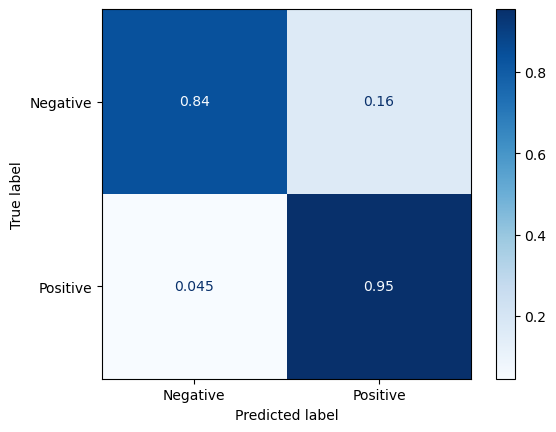

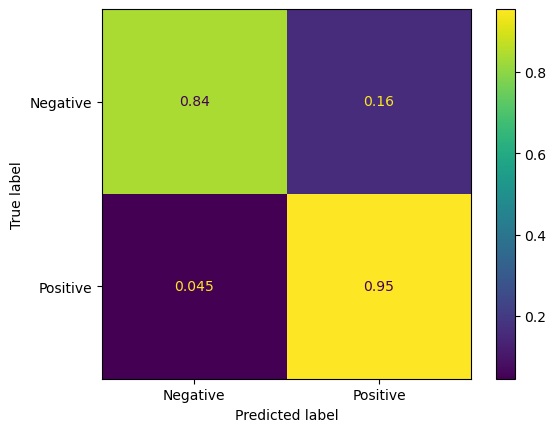

In [177]:
#print(confusion_matrix(y_test, y_pred))
disp = ConfusionMatrixDisplay.from_estimator(est, X_test, y_test,
    display_labels=est.classes_, cmap=plt.cm.Blues, normalize="true",
)
disp.plot()

In [162]:
# print('Classes:',est.classes_)
# vocab = est.get_params()['vectorizer'].vocabulary_
# coeff_pos = est.get_params()['classifier'].feature_log_prob_[1]
# coeff_neg = est.get_params()['classifier'].feature_log_prob_[0]

# from numpy import argsort

# polarity = coeff_pos - coeff_neg
# indices = argsort(polarity) # indices of the polarity list, sorted from least to greatest

# print("Positive Words \n-----")
# for word in vocab:
#     if vocab[word] in indices[-20:]:
#         print(word)

# print("\nNegative Words \n-----")
# for word in vocab:
#     if vocab[word] in indices[:20]:
#         print(word)

In [17]:
#Have a look at the incorrect classifications:

print('Classes:',est.classes_)
def summary(row):
    text = row['text']
    prob = est.predict_proba([text])[0]
    print(f"Predict: {row['predict']}" )
    print(f"Actual:  {row['actual']}" )
    print(f"{est.classes_[0]} score: {prob[0]:.3f}%")
    print(f"{est.classes_[1]} score: {prob[1]:.3f}%")
    print(text)
    tokens_without_sw = [word for word in custom_tokenizer(text) if not word in STOP_WORDS]
    print(tokens_without_sw)
    print()


for index, row in df_correct[0:50].iterrows():
    summary(row)
    

Classes: ['Negative' 'Positive']
Predict: Positive
Actual:  Positive
Negative score: 0.000%
Positive score: 1.000%
I rounded up to 4 stars because this is such a great QPR Pinot. Picked up a mixed case of wine at the Costco on the Big Island and paired this with some salmon. This is a great everyday PN that can be picked up for about $16. Flavors of strawberries, raspberries, cranberries, vanilla, cherry cola, warm spices and oak on the finish.
['great', 'qpr', 'pick', 'mixed', 'case', 'big', 'island', 'pair', 'great', 'everyday', 'pn', 'pick', 'pricetoken', 'cola', 'warm']

Predict: Negative
Actual:  Negative
Negative score: 0.961%
Positive score: 0.039%
Dry, dark and brooding - not worth. $311 though
['dry', 'brood', 'not', 'worth', 'pricetoken']

Predict: Positive
Actual:  Positive
Negative score: 0.000%
Positive score: 1.000%
Very satisfying Aussie Shiraz. Intense aromas of blueberry and black fruit, with some black pepper and chocolate. Quite full bodied, with smooth tannins. Exce

['pretty', 'good', 'pricetoken', 'not', 'would', 'buy', 'again']

Predict: Positive
Actual:  Positive
Negative score: 0.229%
Positive score: 0.771%
This horny lady is pretty pretty pretty good. Also, we picked her up today for $25. She is on the bolder and tannic side as well as dry. Tobacco earth and a little wood with red fruit (not quit cherry but not strawberry either). Pairs quite nicely with this terrible pizza I bought which, like sex, even at its worst is still pretty good
['horny', 'lady', 'pretty', 'pretty', 'pretty', 'good', 'pick', 'today', 'pricetoken', 'bolder', 'well', 'dry', 'little', 'not', 'quit', 'but', 'not', 'either', 'pairs', 'nicely', 'terrible', 'buy', 'like', 'sex', 'bad', 'pretty', 'good']

Predict: Positive
Actual:  Positive
Negative score: 0.000%
Positive score: 1.000%
Pretty nice wine! Very jammy, heavy cherry cola, mild spice, medium dry finish. Smooth tannins. Paid $20 and would do it again.
['pretty', 'nice', 'heavy', 'cola', 'dry', 'pay', 'pricetoken', 

In [104]:
ratings = df_money['ratings']
for i,r in df_money['reviews'].sample(50).items():
    print(f"{est.predict([r])}, {ratings[i]}\n",r)
    print()

['Positive'], 4.0
 Really solid, balanced wine for $13 at TJs! Oregon Pinot expectations. Strawberry fruit roll up?? Gotta dig into junior high memories for that. Nice acidity, soft tannins. Seems richer on the nose than it tastes. Great everyday wine.

['Positive'], 4.0
 Exceptional value. 100% Syrah from northern Rhone but has new oak on it, foregoing the classic pepper, olive, floral, etc, so it ultimately drinks more like a new world Syrah but with lower alcohol and classic old world minerality on the finish. A little bit of cedar and tobacco as well, slightly Bordeaux-like but objectively just wonderful for $37 regardless of category

['Positive'], 3.5
 Lemon and honeydew with daisy, wet stone, and a touch of saltiness. Fabulous weeknight wine with a light salad and chicken. Would def have more, especially for the $10 major bargain.

['Positive'], 4.0
 Great wine for a good value. A little smoke, a little sweet, and a lot of yum! I would definitely recommend if hosting & looking f

['Positive'], 4.5
 Pretty amazing for a $13 bottle of wine!



#### sgd classifier - GRID SEARCH

In [94]:
import emoji
import random
#from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, precision_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

token = 'pricetoken'
#token = ''

def custom_tokenizer(s):
    return  tokenize_lemma(tokenize_price(refine_text(s), token))

print('better = ', tokenize_lemma('better'),
      '<--- if equal, lemma replace is successful')

with open('custom_stop_words.txt', encoding='utf-8') as file:
    stop_words = [line.rstrip() for line in file]
with open('wine_words.txt', encoding='utf-8') as file:
    stop_words_wine = [line.rstrip() for line in file]
with open('vivino_stop_words.txt', encoding='utf-8') as file:
    stop_words_vivino = [line.rstrip() for line in file]

STOP_WORDS = set(stop_words + stop_words_wine + stop_words_vivino)
#STOP_WORDS = set(stop_words_wine+stop_words_vivino)
STOP_WORDS = STOP_WORDS.union({'ll', 've'})
STOP_WORDS = STOP_WORDS.difference({'he', 'his', 'her','hers'})  # Removing a few words that don't lemmatize well

stop_words_lemma = set(tokenize_lemma(' '.join(sorted(STOP_WORDS))))


sgd_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 2), stop_words=stop_words_lemma,
         tokenizer=custom_tokenizer, max_df=0.8,)),  # lemmatization removed to improve runtime
    ('classifier', SGDClassifier(max_iter=50, loss='modified_huber'))
])

#est = sgd_pipe
#est = mnb_pipe

#data = pd.read_csv('./survey_results/ratings_sentiment.csv', encoding='utf-8-sig')
data = pd.read_csv('./survey_results/master_survey.csv', encoding='utf-8-sig')


X = data['reviews']
y = data['sentiment']
seed = random.randint(1, 1e8)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, random_state=seed)


parameters = {'classifier__alpha': (0.0001, 0.0005, 0.001),
               # log = Logistic Regression, hinge = Linear SVM
}
print(f'Training on {len(X_train)} data.')
grid = GridSearchCV(sgd_pipe, parameters, cv=4)
grid.fit(X_train,y_train) # This may take 2 or 3 minutes to run 
est = grid.best_estimator_  #  Let's have a closer look at the best parameters...
y_pred = est.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print('random seed', seed)

print(est.score(X_test, y_test))
print(grid.best_params_)


better =  ['better'] <--- if equal, lemma replace is successful
Training on 1009 data.


C:\Users\steph\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['roast', 's', 'z'] not in stop_words.
  warnings.warn(


KeyboardInterrupt: 

## Sentiment Analysis Model - Star Ratings

In [163]:
import emoji
import random
import pandas as pd
#from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, precision_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier

token = ''
token = ''
def custom_tokenizer(s):
    return  tokenize_lemma(tokenize_price(refine_text(s), token))

print('better = ', tokenize_lemma('better'),
      '<--- if equal, lemma replace is successful')

with open('custom_stop_words.txt', encoding='utf-8') as file:
    stop_words = [line.rstrip() for line in file]
with open('wine_words.txt', encoding='utf-8') as file:
    stop_words_wine = [line.rstrip() for line in file]
with open('vivino_stop_words.txt', encoding='utf-8') as file:
    stop_words_vivino = [line.rstrip() for line in file]

STOP_WORDS = set(stop_words + stop_words_wine + stop_words_vivino)
#STOP_WORDS = set(stop_words_wine+stop_words_vivino)
STOP_WORDS = STOP_WORDS.union({'ll', 've'})
STOP_WORDS = STOP_WORDS.difference({'he', 'his', 'her','hers'})  # Removing a few words that don't lemmatize well

stop_words_lemma = set(tokenize_lemma(' '.join(sorted(STOP_WORDS))))

mnb_pipe = Pipeline([
    ('vectorizer',TfidfVectorizer(ngram_range=(1, 2),stop_words=stop_words_lemma,tokenizer=custom_tokenizer)),
    ('classifier', MultinomialNB()),
])

sgd_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 2), stop_words=stop_words_lemma,
         tokenizer=custom_tokenizer, )),  # lemmatization removed to improve runtime
    ('classifier', SGDClassifier(max_iter=50, loss='modified_huber', alpha=0.0005))
])

est_star = sgd_pipe
#est = mnb_pipe

data = pd.read_csv('./survey_results/ratings_sentiment.csv', encoding='utf-8-sig')
#data = pd.read_csv('./survey_results/master_survey.csv', encoding='utf-8-sig')

X = df_starsentiment['reviews'] 
y = df_starsentiment['sentiment']



seed = random.randint(1, 1e8)
print('random seed', seed)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=seed)

print(f'Training on {len(X_train)} data.')
est_star.fit(X_train, y_train)
print('SGD score:',est_star.score(X_test, y_test))
#y_pred = est.predict(X_test)
y_pred = est_star.predict(X_test)
print(':::::::SGD Classifier results:::::::')
print(classification_report(y_test, y_pred, target_names=est.classes_))


from sklearn.dummy import DummyClassifier
print(':::::::Dummy Classifier results:::::::')
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
print('Dummy score:',dummy_clf.score(X_test, y_test))
print(classification_report(y_test, dummy_clf.predict(X_test), target_names=dummy_clf.classes_))

better =  ['better'] <--- if equal, lemma replace is successful
random seed 20768611
Training on 53003 data.


C:\Users\steph\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['roast', 's', 'z'] not in stop_words.
  warnings.warn(


SGD score: 0.8772168138253716
:::::::SGD Classifier results:::::::
              precision    recall  f1-score   support

    Negative       0.90      0.85      0.87      6675
    Positive       0.85      0.91      0.88      6576

    accuracy                           0.88     13251
   macro avg       0.88      0.88      0.88     13251
weighted avg       0.88      0.88      0.88     13251

:::::::Dummy Classifier results:::::::
Dummy score: 0.50916911931175
              precision    recall  f1-score   support

    negative       0.50      0.50      0.50      6675
    positive       0.49      0.49      0.49      6576

    accuracy                           0.49     13251
   macro avg       0.49      0.49      0.49     13251
weighted avg       0.49      0.49      0.49     13251



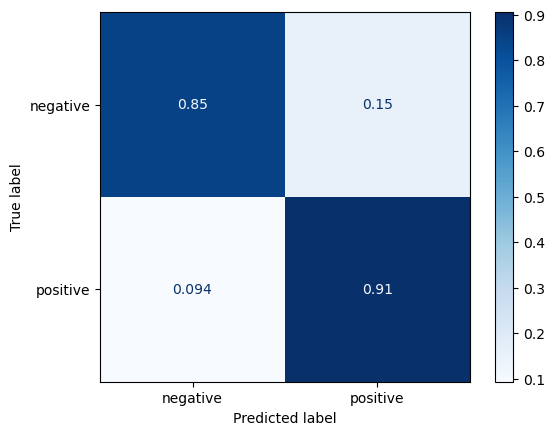

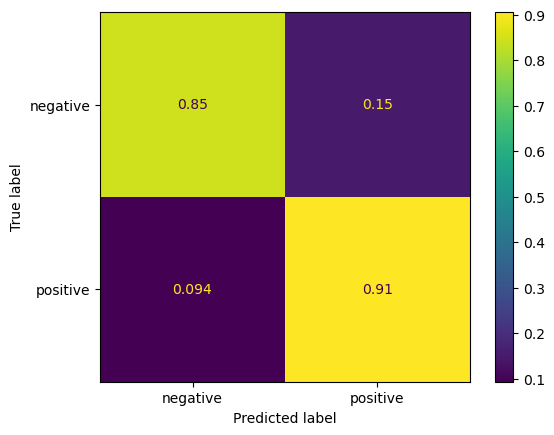

In [164]:
#print(confusion_matrix(y_test, y_pred))
disp = ConfusionMatrixDisplay.from_estimator(est_star, X_test, y_test,
    display_labels=est_star.classes_, cmap=plt.cm.Blues, normalize="true",
)
disp.plot()

## Compare star-sentiment model to price-review training set 

In [165]:
data = pd.read_csv('./survey_results/master_survey.csv', encoding='utf-8-sig')
#data = data.sample(len(data))
X = data['reviews']
y = data['sentiment']
print(len(X))

1683


In [195]:
y_pred = est_star.predict(X)

In [196]:
total = len(y)
hits = 0
for i in range(len(y)):
    if y[i].lower() == y_pred[i]:
        hits += 1
print(hits, total)

281 337


In [197]:
hits/total
#Output ~ 0.84 -- nearly 8-9 points lower than price-sentiment model!! with 50x more data. 

0.8338278931750742

## English reviews with numbers

In [116]:
def has_numbers(inputString):
    try:
        return bool(re.search(r'\d', inputString))
    except:
        #print('FAILURE:', inputString, type(inputString))
        return False

In [117]:
folder_vivino_translated = './vivino_data/'
fname_list = glob(folder_vivino_translated + 'vivino_*')
reviews = []
ratings = []
num_reviews = 0
for fname in tqdm(fname_list):
    df = pd.read_csv(fname, encoding='utf-8-sig')
    df = df[(df['reviews'].apply(has_numbers))
            & (df['detected_language'] == 'ENGLISH')]
    num_reviews += len(df)
    reviews.append(list(df['reviews']))
    ratings.append(list(df['ratings']))

100%|██████████| 6955/6955 [01:57<00:00, 59.33it/s] 


In [118]:
import itertools

reviews = list(itertools.chain(*reviews))
ratings = list(itertools.chain(*ratings))

In [119]:
len(reviews)

467949

# SCRATCH PAD :

In [120]:
fmoney = './money_words.txt'
with open(fmoney, 'r', encoding='utf-8') as file:
    money_words = [line.rstrip() for line in file]

In [121]:
money_reviews = []
money_ratings = []
for i, s in enumerate(reviews):
    if any(money in s for money in money_words):
        money_reviews.append(s)
        money_ratings.append(ratings[i])

In [122]:
dm = pd.DataFrame({'reviews': money_reviews, 'ratings': money_ratings})
print(len(dm), 'out of', len(reviews),
      'of reviews with numbers involve money.')
print(int(len(dm) / len(reviews) * 100), '%')
dm.head()

80662 out of 467949 of reviews with numbers involve money.
17 %


,reviews,ratings
0,"Very nice black fruits, and expressive tannins...",4.0
1,"Rather tasty, but not eager to drop 60 dollars...",4.0
2,"Stellar! . . 2018 vintage, 8/2022, $54. . Dark...",5.0
3,Nice well balanced cab with big vanilla notes ...,5.0
4,"Dark cherry, white pepper, smoke on the expres...",4.5


In [123]:
print('less than 3:', len(dm[(dm['ratings'] < 3)]))
print('more than 3:', len(dm[(dm['ratings'] > 3)]))

less than 3: 4709
more than 3: 66455


In [124]:
dneg = dm[(dm['ratings'] < 3)]
dpos = dm[(dm['ratings'] > 3)]

In [125]:
for s in dneg['reviews'][0:100]:
    print(s + '\n')

This was quite different than my expectations and not in a good way. Not quite in the $2 buck chuck range but for a $40-60 Napa Cab from 2016, I expect more. Disappointing.

Taste like fruit juice. No hints of anything. Gave me terrible headache and wife as well. Drinks like a $10 wine . No idea why people rate higher . You wonder pallets and opinions

Very fruity and easy to drink. Not acidity or tanning. Low subtle and body is light not thick. Had better $20 wine then this one. Will get again if need a fruity wine.

Good, but considering the price, will turn elsewhere next time. And I got it for $42.99. Perhaps it was a different variety of Groth Cab.

I really did not enjoy this at all. It was blah. I decanted and after an hour it was improved but that was from blah to eh. Technical terms these are not. I think I am just not a Cab Franc fan. It must be me. I really could not detect much fruit or much of anything beyond a mid range sourness. Would have liked this lesson at $40 not $4

In [126]:
len(money_reviews)

80662

In [127]:
import random

In [128]:
random.shuffle(money_reviews)
for s in money_reviews[0:30]:
    print(s + '\n')

Super Chianti Classico, we like a lot. Esp when paying £35 in a restaurant!

This wine is fine. It's drinkable like 25-$28 dollar Pinot.

Good, but not remarkable. As others have noted, a wine I’ll probably pull out for non-wine enthusiast guests. Dark purple, and medium bodied. Plum, sage and pepper on the nose, cherry on the pallet. Nice and round with medium tannins and medium / low acidity. Ends with a medium / long finish with similar profile. Aged in French oak 20 months, but it doesn’t come through very strong for me. Good enough wine for $19.

Nice Cab for sale price of $10 CDN

Not fruity, medium flavor, good value. $14 at Pearson’s. .

Light, fruit-forward yet still good balance for $15

Very good wine, red fruits and delicate tannins are present. I bought the magnum, which is good value (50€)

Great value for $10.

Velvet smooth, sophisticated wine for $28. I loved it!

Reduced to £30.00 when I tried it. Very. nice rich. Open for at least 5 hours before drinking

Smooth with

In [129]:
money_reviews_dict = dict(zip(money_words, [[] for _ in money_words]))
for key in tqdm(money_reviews_dict.keys()):
    for s in reviews:
        if key.lower() in s.lower():
            money_reviews_dict[key].append(s)

100%|██████████| 24/24 [00:10<00:00,  2.34it/s]


In [130]:
print('symbol', 'count')
for k, v in money_reviews_dict.items():
    print(k, len(v))

symbol count
$ 59490
USD 1123
CAD 3245
AUD 855
NZD 30
EUR 4845
dollar 1841
buck 3460
€ 4809
euro 2751
£ 7502
pound 329
GBP 80
¥ 178
円 8
Yen 181
JPY 57
₣ 0
franc 6145
CHF 219
₹ 0
rupee 2
₽ 112
ruble 17


In [131]:
print(len(money_reviews_dict['$']), 'out of', len(money_reviews),
      'reviews with moneys have $')
print(int(len(money_reviews_dict['$']) / len(money_reviews) * 100), '%')
print(len(money_reviews_dict['$']), 'out of', len(reviews),
      'reviews with numbers have $')
print(int(len(money_reviews_dict['$']) / len(reviews) * 100), '%')

59490 out of 80662 reviews with moneys have $
73 %
59490 out of 467949 reviews with numbers have $
12 %


## Find reviews with duplicate money_words. Likely they are comparing their purchase to regular prices. 

In [132]:
money_words_freq_in_reviews = [0 for _ in money_reviews]
for i, s in tqdm(enumerate(money_reviews)):
    money_words_freq = [0 for _ in range(len(money_words))]
    keys_found = []
    for j, key in enumerate(money_words):
        money_words_freq[j] = s.lower().count(key.lower())
        if money_words_freq[j] > 0:
            keys_found.append(key.lower())

    money_words_freq_in_reviews[i] = [sum(money_words_freq), s, keys_found]

80662it [00:02, 35321.86it/s]


In [133]:
num_reviews_multiple_money_words = 0
for row in money_words_freq_in_reviews:
    if row[0] > 1:
        num_reviews_multiple_money_words += 1

print('Duplicates:', num_reviews_multiple_money_words, 'out of',
      len(money_words_freq_in_reviews))
print(
    int(num_reviews_multiple_money_words * 100. /
        len(money_words_freq_in_reviews)), '%')

Duplicates: 11905 out of 80662
14 %


In [134]:
multi_dollarsign_reviews = []
single_dollarsign_reviews = []
for i, s in tqdm(enumerate(money_reviews)):
    if s.lower().count('$') > 1:
        multi_dollarsign_reviews.append(s)
    elif s.lower().count('$') == 1:
        single_dollarsign_reviews.append(s)

print('Single $:', len(single_dollarsign_reviews), 'out of',
      len(money_reviews_dict['$']))
print(
    int(len(single_dollarsign_reviews) * 100. / len(money_reviews_dict['$'])),
    '%')

print('Duplicate $:', len(multi_dollarsign_reviews), 'out of',
      len(money_reviews_dict['$']))
print(int(len(multi_dollarsign_reviews) * 100. / len(money_reviews_dict['$'])),
      '%')

80662it [00:00, 470706.10it/s]

Single $: 53888 out of 59490
90 %
Duplicate $: 5602 out of 59490
9 %


In [135]:
import random

random.shuffle(single_dollarsign_reviews)
for s in single_dollarsign_reviews[0:10]:
    print(s + '\n')

One of our go-to wines. Less than $10 grab the nice Tempranillo. Cheers! 😍🍷

Even below $10 per bottle, I was not impressed. Don't waste your money.

For an $18 bottle, this sauvage is amazing. Very fruit forward with hints of toasted walnut. Really nice budget zero dosage.

I think this may be my best under $20 Shiraz! What a regal wine, especially the French oak notes that sing through the whole taste experience. This Shiraz is produced from organic, low yielding vineyards in the McLaren Vale with minimal intervention. Halliday gave it 95. The nose and palate sync beautifully as rich dark berries, sage, salty hoy sin sauce, smoked dried meats and fine pepper and spices fill the senses. The palate is med-bodied, smooth, lifting and slightly drying at the end. A 95/100 (4.2).

Good table wine Chianti, although over priced in the $20+ range. Well balanced and free of exception or complexity, easy to drink and pair.

What an amazing Zin! It is even more amazing considering it is $19.99. 

In [136]:
import

SyntaxError: invalid syntax (2494350585.py, line 1)

In [9]:
import numpy as np

In [10]:
df = pd.read_csv(folder_vivino+'vivino_1163903.csv')
#df = pd.read_csv(folder_vivino + 'vivino_1163903.csv')

[]
[22386, 8854, 7148, 8257]


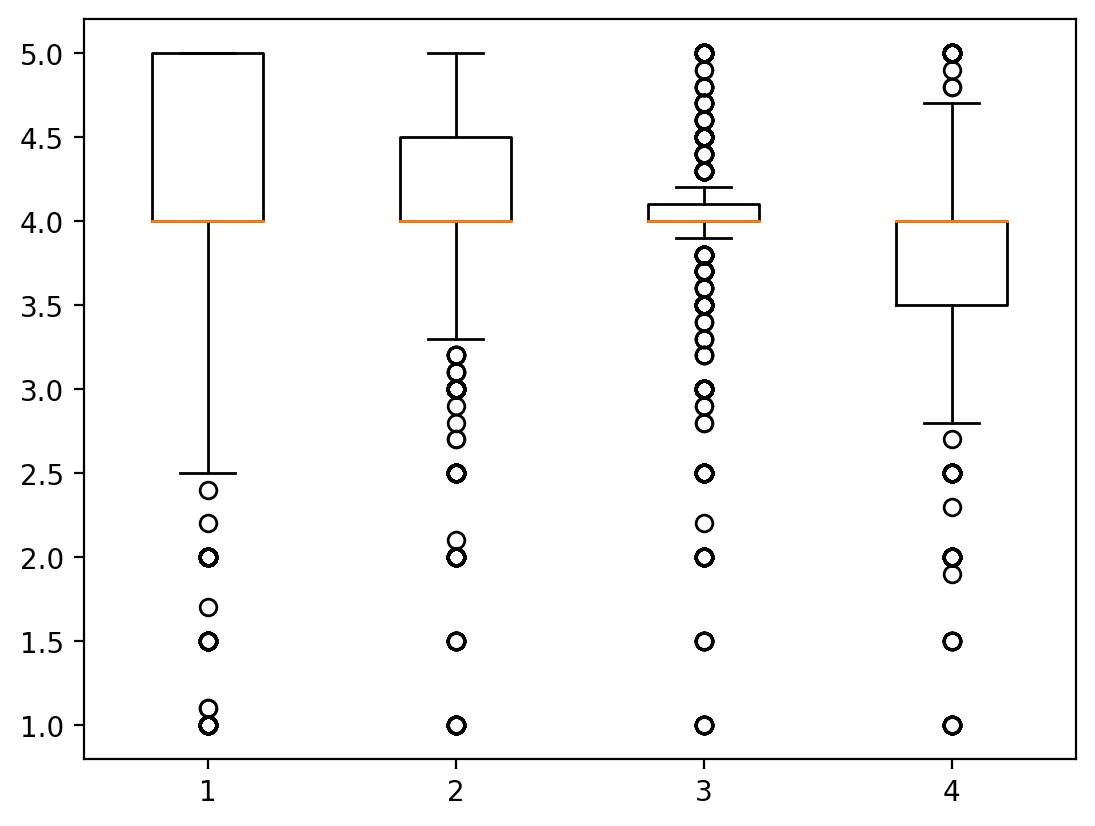

In [11]:
dr = df['user.reviews_count']
print(np.log10([]))
d1 = df[(dr <= 30)]['rating']
d2 = df[(dr > 30) & (dr <= 100)]['rating']
d3 = df[(dr > 100) & (dr <= 300)]['rating']
d4 = df[(dr > 300)]['rating']
#d5 = df[(dr>1000)]['rating']
dd = [d1, d2, d3, d4]
#dd = [d1,d2,d3,d4,d5]

print([len(d) for d in dd])

plt.figure(dpi=200)
plt.boxplot(dd)
plt.show()

<AxesSubplot: >

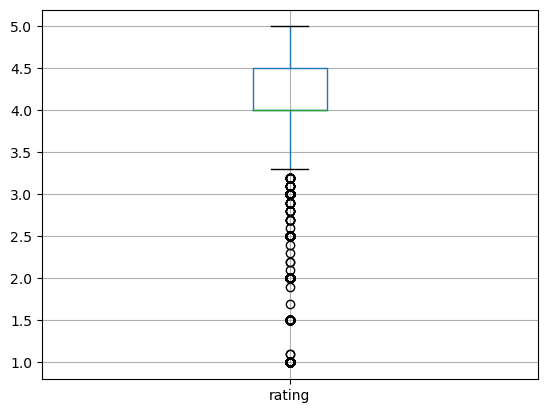

In [12]:
df.boxplot('rating')

In [13]:
print([len(d) for d in dd])

[22386, 8854, 7148, 8257]


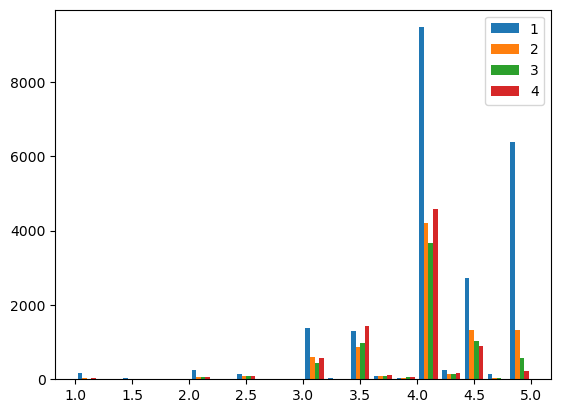

In [14]:
plt.hist(dd, label=[1, 2, 3, 4], bins=20)
plt.legend()

In [15]:
print(df['review'][0])

4 stars.....earthy, with woody taste, smooth yet full bodied....a delight to have on a saturday nite in....well worth the 20 euro price tag


In [16]:
money_reviews = df['review'].str.lower()

money_reviews

0        4 stars.....earthy, with woody taste, smooth y...
1        medium bodied rioja. dark red with a brownish ...
2        not quite as good as i remembered it from my f...
3        this is a rioja staple. as classic as it gets!...
4        very good easy to drink wine. med+ tannins. oa...
                               ...                        
46641                 다시사진않을듯?. 원래49000원짜리 셋트로샀음. 맥마니스가 최고
46642    litt for besk for min smak. ikke noe jeg kjøpe...
46643            sem comentários, simplesmente sensacional
46644                               sauer und unausgewogen
46645    91/100. . 진함. . 익은 체리. 템프라니오에서 오는 향. . 코코넛. 초콜...
Name: review, Length: 46646, dtype: object

In [17]:
from deep_translator import GoogleTranslator
to_translate = 'sem comentários, simplesmente sensacional'
translated = GoogleTranslator(
    source='auto', target='en').translate(to_translate)
translated
# outpout -> Ich möchte diesen Text übersetzen

'no comments, simply sensational'

In [18]:
plt.scatter

<function matplotlib.pyplot.scatter(x, y, s=None, c=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, *, edgecolors=None, plotnonfinite=False, data=None, **kwargs)>

In [19]:
import numpy as np

In [20]:
df = pd.read_csv(folder_vivino + 'vivino_1163903.csv')

In [21]:
df.columns

Index(['Unnamed: 0', 'rating', 'review', 'language', 'time', 'user.id',
       'user.user', 'user.name', 'user.followers_count',
       'user.followings_count', 'user.ratings_count', 'user.ratings_sum',
       'user.reviews_count', 'vintage.id', 'vintage.seo', 'vintage.name',
       'vintage.status', 'vintage.image', 'wine.name', 'wine.region',
       'wine.country', 'winery.name', 'winery.ratings_count',
       'winery.ratings_average', 'winery.labels_count', 'winery.wines_count',
       'flavours', 'likes_count', 'comments_count', 'vintage.year'],
      dtype='object')

C:\Users\steph\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


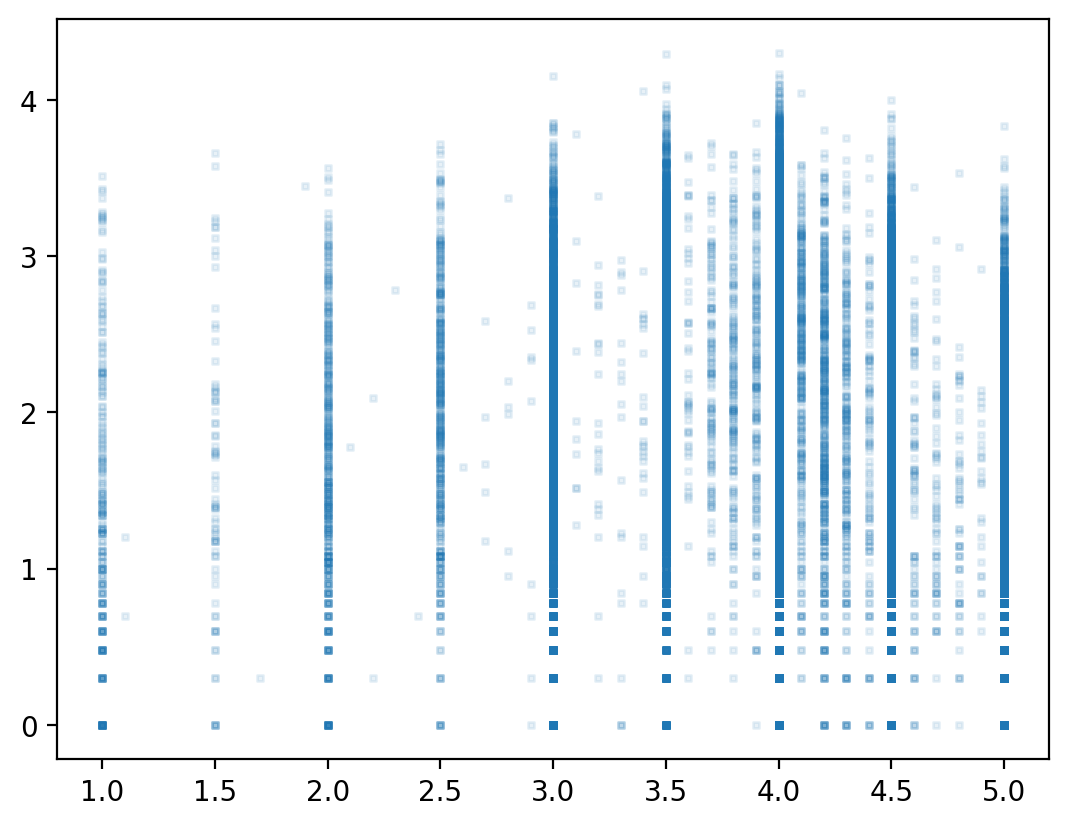

In [22]:
plt.figure(dpi=200)
plt.scatter(df['rating'], np.log10(df['user.ratings_count']),
            marker='s', s=5, alpha=0.1)
#plt.scatter(df['rating'],df['user.ratings_count'],  marker='s',s = 5, alpha=0.1)

[]
[13895, 17345, 12785, 2620]


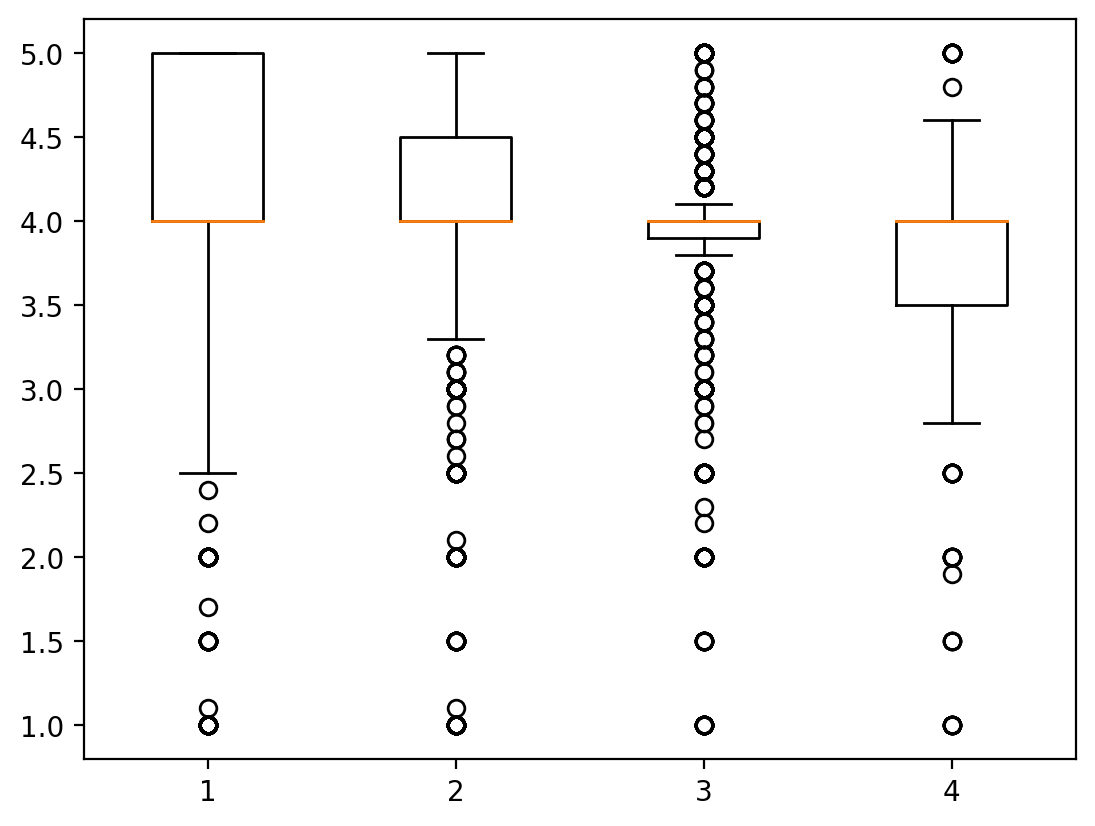

In [23]:
dr = df['user.reviews_count']
print(np.log10([]))
d1 = df[(dr <= 10)]['rating']
d2 = df[(dr > 10) & (dr <= 100)]['rating']
d3 = df[(dr > 100) & (dr <= 1000)]['rating']
d4 = df[(dr > 1000)]['rating']
#d5 = df[(dr>1000)]['rating']
dd = [d1, d2, d3, d4]
#dd = [d1,d2,d3,d4,d5]

print([len(d) for d in dd])

plt.figure(dpi=200)
plt.boxplot(dd)
plt.show()

In [24]:
import seaborn as sns
sns.set()

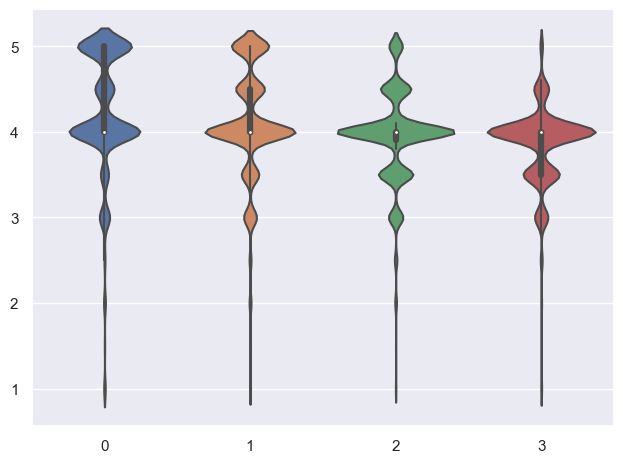

In [25]:
sns.violinplot(data=dd)

plt.tight_layout()

In [26]:
df['flavours']

0                                     ['earthy']
1                                       ['plum']
2                   ['cherry', 'oak', 'vanilla']
3                         ['tobacco', 'vanilla']
4        ['jam', 'oak', 'strawberry', 'vanilla']
                          ...                   
46641                                         []
46642                                         []
46643                                         []
46644                                         []
46645                                         []
Name: flavours, Length: 46646, dtype: object

In [27]:
import itertools
flavour = [f.strip('[]').replace('\'', '').split(',') for f in df['flavours']]
flavour = [f.strip() for f in list(itertools.chain(*flavour))]

In [28]:
from collections import Counter
b = Counter(flavour).most_common()[1:]
b

[('oak', 2351),
 ('vanilla', 1756),
 ('cherry', 1286),
 ('leather', 1281),
 ('tobacco', 1087),
 ('plum', 895),
 ('earthy', 800),
 ('blackberry', 545),
 ('pepper', 486),
 ('oaky', 447),
 ('chocolate', 436),
 ('dark fruit', 416),
 ('red fruit', 396),
 ('smoke', 295),
 ('cheese', 238),
 ('licorice', 222),
 ('cedar', 220),
 ('balsamic', 204),
 ('black cherry', 196),
 ('raspberry', 175),
 ('black fruit', 172),
 ('strawberry', 163),
 ('cinnamon', 143),
 ('blackberries', 140),
 ('smoky', 139),
 ('blueberry', 135),
 ('blackcurrant', 93),
 ('black fruits', 86),
 ('coconut', 83),
 ('coffee', 82),
 ('black currant', 82),
 ('dark chocolate', 82),
 ('mushroom', 80),
 ('red cherry', 72),
 ('leathery', 68),
 ('cassis', 68),
 ('cocoa', 67),
 ('prune', 65),
 ('dill', 65),
 ('jam', 62),
 ('fig', 57),
 ('creamy', 57),
 ('caramel', 54),
 ('cigar box', 50),
 ('cigar', 49),
 ('savory', 46),
 ('prunes', 46),
 ('butter', 43),
 ('anise', 42),
 ('clove', 42),
 ('buttery', 41),
 ('forest floor', 40),
 ('citrus',

In [29]:
reviews = df['review'].str.lower()
reviews.str.contains('$|£|€|dollar|euro|price|bucks|money')

0        True
1        True
2        True
3        True
4        True
         ... 
46641    True
46642    True
46643    True
46644    True
46645    True
Name: review, Length: 46646, dtype: object

In [31]:
for i, r in enumerate(df['review']):
    if '$' in r:
        print(
            f'({int(df["user.ratings_count"][i])}) {df["user.name"][i]}:  ', r+'\n')

(260) Richard Leaper:   Medium ruby. Nice level of American oak on the nose. Dry, elegant, medium tannins, good acidity, great balance, medium/long finish. Very good structure and appealing notes of vanilla and cedar. Classic Rioja. Definite rebuy. . 14.5% ABV. 96/4 Tempranillo/Graciano. $20 at Specs.

(206) Jay McCarron:   3.9 or 4.0. Very nice for $15. Lots of tobacco and earthy tones, I got more red fruit than dark. Also a hint of pepper on the finish. Stood up to spicy food well. Good acidity and medium tannins, medium bodied. Medium finish.

(66) Clay Cannaday:   For qpr it’s the best rioja I’ve enjoyed. Unreal complexity for the price point. Red fruit, leather, oak on the palate. Very happy to spend $15 on this.

(630) Oenophiliac:   3.5 stars. Pretty good wine, but too high a price point at $20 in my humble opinion. Nose: very dark fruit, oak, blackberry and perfume. Taste: very sharp tannins with dark fruit, plum skin, dark raisin, and salt. Very acidic.

(10) Tom Gorrell:   Gr

TypeError: argument of type 'float' is not iterable

In [6]:
import requests

In [39]:
r = requests.post('http://127.0.0.2:5000/translate',
                  params={
                      "q": "Nez d agrumes, bouche très simple.",
                      "source": "fr",
                      "target": "en",
                      "format": "text",
                      "api_key": "",

                  }



                  )

In [40]:
r.json()

{'translatedText': 'Nose of citrus, very simple mouth.'}

In [100]:
import os
import random
from pyspark import SparkContext, SparkConf
import pyspark

In [101]:
pyspark.__version__

'3.2.1'

In [102]:
from pyspark.sql import SQLContext
import os
import random
from pyspark import SparkContext, SparkConf

sc = SparkContext('local[*]', 'pyspark_df')
print(sc.version)

# Alternatively...
# conf = SparkConf().setAppName('pyspark_df').setMaster('local[*]')
# sc = SparkContext(conf=conf)
# needed to convert RDDs into DataFrames
sqlContext = SQLContext(sc)

Py4JJavaError: An error occurred while calling None.org.apache.spark.api.java.JavaSparkContext.
: java.lang.NoClassDefFoundError: Could not initialize class org.apache.spark.storage.StorageUtils$
	at org.apache.spark.storage.BlockManagerMasterEndpoint.<init>(BlockManagerMasterEndpoint.scala:110)
	at org.apache.spark.SparkEnv$.$anonfun$create$9(SparkEnv.scala:348)
	at org.apache.spark.SparkEnv$.registerOrLookupEndpoint$1(SparkEnv.scala:287)
	at org.apache.spark.SparkEnv$.create(SparkEnv.scala:336)
	at org.apache.spark.SparkEnv$.createDriverEnv(SparkEnv.scala:191)
	at org.apache.spark.SparkContext.createSparkEnv(SparkContext.scala:277)
	at org.apache.spark.SparkContext.<init>(SparkContext.scala:460)
	at org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
	at java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
	at java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
	at java.base/java.lang.reflect.Constructor.newInstanceWithCaller(Constructor.java:499)
	at java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:480)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:238)
	at py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
	at py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:833)


In [257]:
from lingua import LanguageDetectorBuilder, Language, IsoCode639_1, IsoCode639_3

# Include all languages available in the library.
detector = LanguageDetectorBuilder.from_all_languages().with_low_accuracy_mode().build()

In [258]:
detector.detect_language_of(
    "hello, my name is stephen ro and I am happy to see you.")

Language.ENGLISH

In [ ]:
detector.detect_language_of(
    "hello, my name is stephen ro and I am happy to see you.")

In [276]:
df['reviews'].apply(lambda x: detector.detect_language_of(x).name)

AttributeError: 'NoneType' object has no attribute 'name'

In [279]:
for r in df['reviews']:
    try:
        detector.detect_language_of(r).name
    except:
        print(r)
        p = detector.detect_language_of(r)
        print(detector.detect_language_of(r))

3.8
None
3
None
9,1 PM
None
@92
None
4.3
None
4.3
None
4,3
None
4.4
None
4.2
None
8,0/10
None
91/100
None
4.3
None
4.1. 🍷🍷🍷🍷
None
3.9
None
3,8🌟
None
87
None
4,1
None
4,2
None
4.2
None
4.1
None
4,3
None
4.1
None
3.8
None
4.2🌟
None
3.5+
None
93
None
4.2
None
4.1
None
17.0/20
None
PN 86. FI.
None
4.1
None
91 😊😊😊😊
None
4.2
None
3.9
None
91/100
None
4,2
None
8.9 PM
None
4,2
None
3,7
None
4,2
None
4.1
None
4,2
None
4,1 140 VH
None
(4.0)
None
3
None
3,9
None
3,3
None
4,3
None
4.1
None
4.1
None
18/20
None
4.1
None
3.7
None
22
None
4.5
None
3.8
None


In [283]:
type(p)

NoneType

In [284]:
type(None)

NoneType

In [285]:
test = df.copy(deep=True)

In [290]:
print(test['reviews'][0])
test['reviews'][0] = None
print(test['reviews'][0])

91/100 Aroma had dark berries and vanilla. Flavor had dark lack currant, black cherries, spices, oak and vanilla. Nice balance and depth.
None


C:\Users\steph\AppData\Local\Temp\ipykernel_14184\2036168479.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['reviews'][0] = None


In [9]:
value = 10000000
f"{value:,}"

'10,000,000'